In [26]:
import pandas as pd

df = pd.read_csv('Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [14]:
df.shape

(27480, 5)

In [4]:
df.isnull().values.any() 

True

In [5]:
df = df.dropna()
df.duplicated().sum()

0

In [6]:
df = df.reset_index(drop = True)
df.tail()

,textID,text,selected_text,sentiment
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27479,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [7]:
df['label_id'] = df['sentiment'].factorize()[0]
cat_id = df[['sentiment', 'label_id']].drop_duplicates().sort_values('label_id')
cat_to_id = dict(cat_id.values)
id_to_cat = dict(cat_id[['label_id', 'sentiment']].values)

id_to_cat

{0: 'neutral', 1: 'negative', 2: 'positive'}

In [8]:
label = df['label_id'].values
text = df['selected_text'].values

print('Value of [label]:', label, "\n")
print('Value of [text]:', text)

Value of [label]: [0 1 1 ... 2 2 0] 

Value of [text]: ['I`d have responded, if I were going' 'Sooo SAD' 'bullying me' ...
 'Yay good for both of you.' 'But it was worth it  ****.'
 'All this flirting going on - The ATG smiles. Yay.  ((hugs)']


In [25]:
maxfeatures = 10000

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = maxfeatures)
tokenizer.fit_on_texts(text)

maxseqlen = max([len(i.split()) for i in text])
print(maxseqlen)

33


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, maxseqlen)
y = to_categorical(label, num_classes = 3)

print("Shape of data tensor ['text']:", X.shape)
print("Shape of data tensor ['label']:", y.shape)

Shape of data tensor ['text']: (27480, 33)
Shape of data tensor ['label']: (27480, 3)


In [15]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

(21984, 33) (21984, 3)
(5496, 33) (5496, 3)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Embedding, Dense, GlobalMaxPool1D
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(input_dim = maxfeatures, output_dim = 128, input_length = maxseqlen))
model.add(LSTM(128, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))


opt = RMSprop(learning_rate=0.0012, rho=0.7, momentum=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 33, 128)           131584    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                        

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3)

In [18]:
from datetime import datetime

start_time = datetime.now()
history = model.fit(Xtrain, ytrain,
                    batch_size = 100, epochs = 15, shuffle = True,
                    validation_split = 0.1, verbose = 1,
                    callbacks=early_stop)
end_time = datetime.now()
print("Time out: {}".format(end_time - start_time))

Epoch 1/15
198/198 [==============================] - 13s 56ms/step - loss: 0.7726 - accuracy: 0.6580 - val_loss: 0.5443 - val_accuracy: 0.7890
Epoch 2/15
198/198 [==============================] - 11s 58ms/step - loss: 0.4767 - accuracy: 0.8251 - val_loss: 0.4625 - val_accuracy: 0.8208
Epoch 3/15
198/198 [==============================] - 11s 54ms/step - loss: 0.3867 - accuracy: 0.8622 - val_loss: 0.4401 - val_accuracy: 0.8386
Epoch 4/15
198/198 [==============================] - 11s 55ms/step - loss: 0.3395 - accuracy: 0.8848 - val_loss: 0.4301 - val_accuracy: 0.8404
Epoch 5/15
198/198 [==============================] - 11s 57ms/step - loss: 0.2954 - accuracy: 0.8998 - val_loss: 0.4488 - val_accuracy: 0.8508
Epoch 6/15
198/198 [==============================] - 12s 61ms/step - loss: 0.2605 - accuracy: 0.9142 - val_loss: 0.4541 - val_accuracy: 0.8354
Epoch 7/15
198/198 [==============================] - 13s 64ms/step - loss: 0.2305 - accuracy: 0.9253 - val_loss: 0.4759 - val_accuracy:

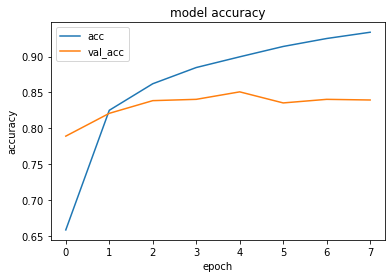

In [19]:
import matplotlib.pyplot as plt

plt.plot (history.history['accuracy'])
plt.plot (history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

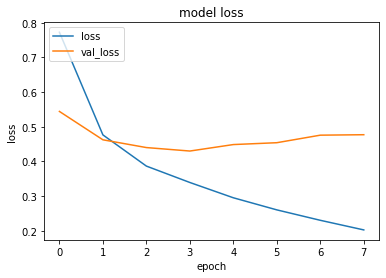

In [20]:
import matplotlib.pyplot as plt

plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score

def evaluation(model, X, Y):
  global Y_pred, Y_act
  Y_pred = model.predict(X)
  Y_pred_class = np.argmax(Y_pred, axis=1)
  rounded_labels=np.argmax(Y, axis=1)
  Y_act = rounded_labels
  
  accuracy = accuracy_score(Y_act, Y_pred_class)
  return accuracy

In [28]:
import numpy as np

accuracy = evaluation(model, Xtest, ytest)
print('accuracy: %.3f' % (accuracy * 100), '%')

172/172 [==============================] - 1s 7ms/step
accuracy: 82.878 %


In [24]:
from sklearn.metrics import confusion_matrix, classification_report

target = ['neu', 'neg', 'pos']
print(confusion_matrix(Y_act, np.argmax(Y_pred, axis=1)))
print(classification_report(Y_act, np.argmax(Y_pred, axis = 1), target_names = target))

[[1867  209  160]
 [ 221 1283   68]
 [ 185   98 1405]]
              precision    recall  f1-score   support

         neu       0.82      0.83      0.83      2236
         neg       0.81      0.82      0.81      1572
         pos       0.86      0.83      0.85      1688

    accuracy                           0.83      5496
   macro avg       0.83      0.83      0.83      5496
weighted avg       0.83      0.83      0.83      5496

